In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import shutil
from collections import Counter


MLP:
- Increase batch size to 256
- Decrease epochs to 20
- self.dropout1 = nn.Dropout(0.5 a 0.6)
- self.dropout2 = nn.Dropout(0.2 a 0.5)

In [2]:
filepath = 'Tests/2'
script_dir = os.path.dirname('mlp.ipynb')
results_dir = os.path.join(script_dir, filepath + '/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

In [3]:
# Load Data

# Uncomment to save .npy file if not yet saved
#data =  np.loadtxt('./test_series.csv',delimiter=',',dtype=np.float32)
#np.save('test_series', data)
xy = np.load('./coin_data.npy')

X = xy[:,1:] # Indexes inputs

# Turns negative values to 0
X[X < 0] = 0

y = xy[:,0] # Indexes Labels
#label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(y)
#print(type(y[0]))

In [4]:
# Create sliding windows
def create_sliding_windows(data, labels, window_size=1024, step_size=512):
    """
    Create sliding windows for all time series in the dataset.
    """
    all_windows = []
    all_labels = []
    for i, row in enumerate(data):
        label = labels[i]
        time_series = row
        num_windows = (len(time_series) - window_size) // step_size + 1
        for j in range(num_windows):
            start = j * step_size
            window = time_series[start:start + window_size]
            all_windows.append(window)
            all_labels.append(label)
    return np.array(all_windows), np.array(all_labels)

In [5]:
# Majority voting
def majority_vote(predictions):
    """
    Perform majority voting on predictions for a single time-series.
    """
    vote_count = Counter(predictions)
    return vote_count.most_common(1)[0][0]

In [6]:
# Create sliding windows
windows, window_labels = create_sliding_windows(X, y, window_size=1024, step_size=512)

In [7]:
print(f'XY Shape: {xy.shape}')
print(f'xy[0]: {xy[0]}')
print(f'X[0]: {X[0]}')
print(f'y[0]: {y[0]}')

coin_1 = 0
coin_2 = 0
coin_5 = 0
coin_20 = 0
coin_50 = 0
coin_100 = 0
coin_200 = 0
for i in range(xy.shape[0]):
    if xy[i,0] == 0:
        coin_1 += 1
    elif xy[i,0] == 1:
        coin_2 += 1
    elif xy[i,0] == 2:
        coin_5 += 1
    elif xy[i,0] == 3:
        coin_20 += 1
    elif xy[i,0] == 4:
        coin_50 += 1
    elif xy[i,0] == 5:
        coin_100 += 1
    elif xy[i,0] == 6:
        coin_200 += 1
print(f'coin 1: {coin_1}')
print(f'coin 2: {coin_2}')
print(f'coin 5: {coin_5}')
print(f'coin 20: {coin_20}')
print(f'coin 50: {coin_50}')
print(f'coin 100: {coin_100}')
print(f'coin 200: {coin_200}')

XY Shape: (1094, 769025)
xy[0]: [   5.    0.    0. ... 1040.  912.  640.]
X[0]: [   0.    0.    0. ... 1040.  912.  640.]
y[0]: 5.0
coin 1: 151
coin 2: 170
coin 5: 130
coin 20: 137
coin 50: 130
coin 100: 180
coin 200: 196


In [8]:
# Set random seed for reproducibility
torch.manual_seed(7)  # Set the seed for generating random numbers in PyTorch
np.random.seed(7)     # Set the seed for generating random numbers in NumPy

In [9]:
# Define Hyper Parameters

hidden_size = 512
num_classes = 7
num_epochs = 25
batch_size = 256
learning_rate = 0.0001
num_layers = 2

input_size = 1024



In [10]:

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Before normalization X_train[0]: [  0.  64. 352. ...   0.  96.  64.]


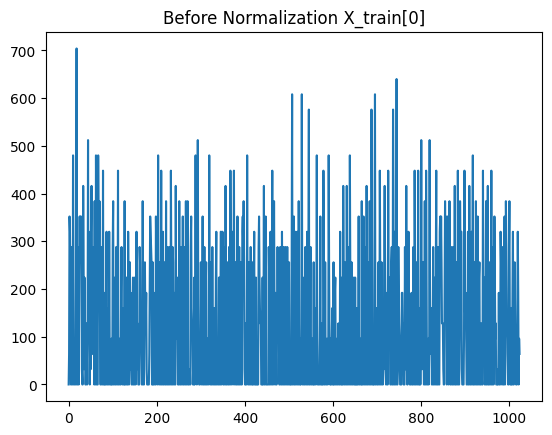

After normalization X_train[0]: [  0.  64. 352. ...   0.  96.  64.]


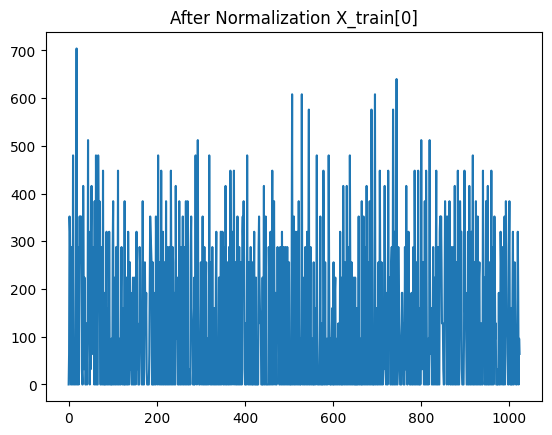

In [11]:
# Random State So it is reproducible
X_train, X_test, y_train, y_test = train_test_split(windows, window_labels, test_size=0.2, random_state=1234)

# Graph before normalization
print(f'Before normalization X_train[0]: {X_train[0]}')
plt.figure()
plt.title("Before Normalization X_train[0]")
plt.plot(X_train[0])
plt.show()

# Scale and split data
sc = MinMaxScaler(feature_range=(0,1))

# Per sample scaling
#X_train = np.array([sc.fit_transform(sample.reshape(-1, 1)).flatten() for sample in X_train])
#X_test = np.array([sc.fit_transform(sample.reshape(-1, 1)).flatten() for sample in X_test])

# Graph after scaling
#print(f'After normalization X_train[0]: {X_train[0]}')
#plt.figure()
#plt.title("After Per Sample Normalization X_train[0]")
#plt.plot(X_train[0])
#plt.show()

# Global scaling
# sc.fit_transform on X_train and sc.transform on X_test to avoid data leakage
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# Graph after scaling
print(f'After normalization X_train[0]: {X_train[0]}')
plt.figure()
plt.title("After Normalization X_train[0]")
plt.plot(X_train[0])
plt.show()

In [12]:
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')
print(f'X_test[0]: {X_test[0]}')
print(f'y_test[0]: {y_test[0]}')

train_coin_1 = 0
train_coin_2 = 0
train_coin_5 = 0
train_coin_20 = 0
train_coin_50 = 0
train_coin_100 = 0
train_coin_200 = 0

for i in range(y_train.shape[0]):
    if y_train[i] == 0:
        train_coin_1 += 1
    elif y_train[i] == 1:
        train_coin_2 += 1
    elif y_train[i] == 2:
        train_coin_5 += 1
    elif y_train[i] == 3:
        train_coin_20 += 1
    elif y_train[i] == 4:
        train_coin_50 += 1
    elif y_train[i] == 5:
        train_coin_100 += 1
    elif y_train[i] == 6:
        train_coin_200 += 1
        
print(f'coin 1: {train_coin_1}')
print(f'coin 2: {train_coin_2}')
print(f'coin 5: {train_coin_5}')
print(f'coin 20: {train_coin_20}')
print(f'coin 50: {train_coin_50}')
print(f'coin 100: {train_coin_100}')
print(f'coin 200: {train_coin_200}')

test_coin_1 = 0
test_coin_2 = 0
test_coin_5 = 0
test_coin_20 = 0
test_coin_50 = 0
test_coin_100 = 0
test_coin_200 = 0
for i in range(y_test.shape[0]):
    if y_test[i] == 0:
        test_coin_1 += 1
    elif y_test[i] == 1:
        test_coin_2 += 1
    elif y_test[i] == 2:
        test_coin_5 += 1
    elif y_test[i] == 3:
        test_coin_20 += 1
    elif y_test[i] == 4:
        test_coin_50 += 1
    elif y_test[i] == 5:
        test_coin_100 += 1
    elif y_test[i] == 6:
        test_coin_200 += 1
print(f'coin 1: {test_coin_1}')
print(f'coin 2: {test_coin_2}')
print(f'coin 5: {test_coin_5}')
print(f'coin 20: {test_coin_20}')
print(f'coin 50: {test_coin_50}')
print(f'coin 100: {test_coin_100}')
print(f'coin 200: {test_coin_200}')

X_train[0]: [  0.  64. 352. ...   0.  96.  64.]
y_train[0]: 2.0
X_test[0]: [   0.    0.    0. ...    0.  160. 2400.]
y_test[0]: 0.0
coin 1: 181169
coin 2: 204140
coin 5: 156108
coin 20: 164747
coin 50: 156284
coin 100: 216212
coin 200: 235015
coin 1: 45482
coin 2: 51030
coin 5: 39022
coin 20: 40890
coin 50: 38846
coin 100: 53968
coin 200: 59181


In [13]:
# Creates TrainCoinDataSet
class TrainCoinDataSet(Dataset):

    def __init__(self, X_train, y_train):
        # Data Loading
        self.x = torch.from_numpy(X_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.n_samples = y_train.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples
    
class TestCoinDataSet(Dataset):

    def __init__(self, X_test, y_test):
        # Data Loading
        self.x = torch.from_numpy(X_test.astype(np.float32))
        self.y = torch.from_numpy(y_test).type(torch.LongTensor)
        self.n_samples = y_test.shape[0] # n_samples
        print(self.n_samples)

    def __getitem__(self, index):
        # Allows indexing
        return self.x[index], self.y[index]

    def __len__(self):
        # Allows calling length
        return self.n_samples

In [14]:
# Creates Dataset
train_data = TrainCoinDataSet(X_train, y_train)
test_data = TestCoinDataSet(X_test, y_test)

1313675
328419


In [15]:
print(train_data[0])
print(test_data[0])

(tensor([  0.,  64., 352.,  ...,   0.,  96.,  64.]), tensor(2))
(tensor([   0.,    0.,    0.,  ...,    0.,  160., 2400.]), tensor(0))


In [16]:
# Defines Train and Test Datasets sizes
#train_size = int(0.8 * len(dataset))  # 80% of the data will be used for training
#test_size = len(dataset) - train_size  # Remaining 20% will be used for test

# Split dataset into training set and test set
#train_data, test_data = random_split(dataset, [train_size, test_size])

# Creates Dataloaders for train and test datasets
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

examples = iter(train_loader)
samples, labels = next(examples)


In [17]:
print(f'Input shape: {samples.shape} , Labels shape: {labels.shape}')
print(f"Input range after standardization: Min = {samples[0].min()}, Max = {samples[0].max()}")
print(samples[0])
print(labels[0])
print(f'Input dtype: {samples[0,0].dtype}')
print(f'Label dtype: {labels[0].dtype}')
print(f'Labels: {labels}')

Input shape: torch.Size([256, 1024]) , Labels shape: torch.Size([256])
Input range after standardization: Min = 0.0, Max = 11648.0
tensor([  0.,   0.,   0.,  ..., 448.,   0.,   0.])
tensor(3)
Input dtype: torch.float32
Label dtype: torch.int64
Labels: tensor([3, 3, 6, 0, 6, 5, 2, 6, 0, 2, 6, 1, 4, 6, 0, 2, 6, 2, 3, 0, 2, 6, 5, 2,
        2, 6, 6, 1, 1, 6, 2, 6, 1, 5, 0, 3, 2, 0, 1, 1, 4, 3, 2, 6, 0, 2, 1, 4,
        0, 6, 1, 2, 3, 3, 3, 6, 3, 0, 1, 4, 6, 5, 1, 0, 1, 0, 3, 5, 1, 5, 3, 1,
        6, 3, 0, 1, 2, 1, 3, 3, 5, 1, 1, 4, 0, 6, 3, 3, 3, 0, 5, 5, 6, 2, 2, 5,
        5, 1, 0, 0, 0, 1, 5, 6, 1, 4, 6, 2, 4, 1, 2, 4, 6, 4, 1, 3, 5, 5, 4, 6,
        4, 0, 5, 2, 4, 0, 6, 6, 2, 6, 0, 5, 1, 6, 5, 6, 0, 4, 6, 1, 5, 1, 6, 6,
        0, 6, 3, 5, 1, 0, 2, 6, 3, 6, 2, 6, 6, 6, 4, 0, 0, 1, 5, 0, 5, 0, 1, 1,
        5, 5, 3, 6, 2, 5, 1, 1, 5, 0, 4, 1, 5, 1, 5, 6, 6, 6, 5, 5, 0, 4, 4, 5,
        6, 0, 4, 6, 5, 1, 3, 1, 6, 4, 5, 5, 3, 3, 2, 0, 0, 1, 3, 3, 3, 4, 3, 1,
        4, 1, 4, 5, 2, 0, 3,

In [18]:
# Create Model

# Model 
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(0.6)
        
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        
        # output layer
        self.fc3 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self,x):
        
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)

        out = self.fc3(out)
        # softmax

        return out

In [19]:
model = MLP(input_size, num_classes).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning Rate Scheduler (Reduce by factor of 0.1 every 10 epochs)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Reduces learning rate if loss plateaus
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [20]:
print(model)

MLP(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (relu): ReLU()
)


In [21]:
# Training loop

history = {'train_loss': [], 'val_loss': [], 'train_acc':[], 'val_acc': []}
all_preds = []
all_labels = []

train_loss_steps = []
train_acc_steps = []
running_loss_train_steps = 0.0
n_correct_train_steps = 0
n_samples_train_steps = 0

plot_steps, print_steps = 8,1

running_loss_train = 0.0
n_correct_train = 0
n_samples_train = 0

running_loss_val = 0.0
n_correct_val = 0
n_samples_val = 0

for epoch in range(num_epochs):
    
    model.train()
    running_loss_train = 0.0
    n_correct_train = 0
    n_samples_train = 0

    # Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # For Epoch Graph
        running_loss_train += loss.item()
        _, predictions = torch.max(outputs, 1)
        n_correct_train += (predictions == labels).sum().item()
        n_samples_train += labels.shape[0]

        # For Steps Graph
        running_loss_train_steps += loss.item()
        _, predictions = torch.max(outputs, 1)
        n_correct_train_steps += (predictions == labels).sum().item()
        n_samples_train_steps += labels.shape[0]
        
        if (i+1) % print_steps == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{len(train_loader)}, loss = {loss.item():.4f}')

        if (i+1) % plot_steps == 0:
            train_loss_steps.append(running_loss_train_steps / len(train_loader))
            train_acc_steps.append(100 * n_correct_train_steps / n_samples_train_steps)
            running_loss_train_steps = 0.0
            n_correct_train_steps = 0
            n_samples_train_steps = 0


    history['train_loss'].append(running_loss_train / len(train_loader))
    history['train_acc'].append(100 * n_correct_train / n_samples_train)

    # Test loop

    running_loss_val = 0.0
    n_correct_val = 0
    n_samples_val = 0

    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Accumulate loss
            running_loss_val += loss.item()
            _, predictions = torch.max(outputs, 1)
            n_correct_val += (predictions == labels).sum().item()
            n_samples_val += labels.shape[0]

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if (i+1) % print_steps == 0:
                print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{len(test_loader)}, loss = {loss.item():.4f}')

        history['val_loss'].append(running_loss_val / len(test_loader))
        history['val_acc'].append(100 * n_correct_val / n_samples_val)

epoch 1 / 25, step 1/5132, loss = 1224.8864
epoch 1 / 25, step 2/5132, loss = 1208.3573
epoch 1 / 25, step 3/5132, loss = 1320.6913
epoch 1 / 25, step 4/5132, loss = 1007.2255
epoch 1 / 25, step 5/5132, loss = 869.5057
epoch 1 / 25, step 6/5132, loss = 1634.3438
epoch 1 / 25, step 7/5132, loss = 566.1736
epoch 1 / 25, step 8/5132, loss = 499.5794
epoch 1 / 25, step 9/5132, loss = 559.3463
epoch 1 / 25, step 10/5132, loss = 646.7465
epoch 1 / 25, step 11/5132, loss = 671.3423
epoch 1 / 25, step 12/5132, loss = 509.3060
epoch 1 / 25, step 13/5132, loss = 1439.3672
epoch 1 / 25, step 14/5132, loss = 595.1981
epoch 1 / 25, step 15/5132, loss = 676.1529
epoch 1 / 25, step 16/5132, loss = 886.1273
epoch 1 / 25, step 17/5132, loss = 845.9709
epoch 1 / 25, step 18/5132, loss = 921.5580
epoch 1 / 25, step 19/5132, loss = 841.4664
epoch 1 / 25, step 20/5132, loss = 1057.7980
epoch 1 / 25, step 21/5132, loss = 892.5986
epoch 1 / 25, step 22/5132, loss = 790.4554
epoch 1 / 25, step 23/5132, loss =

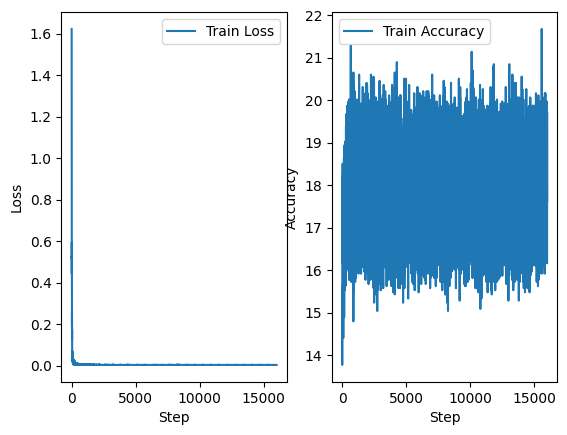

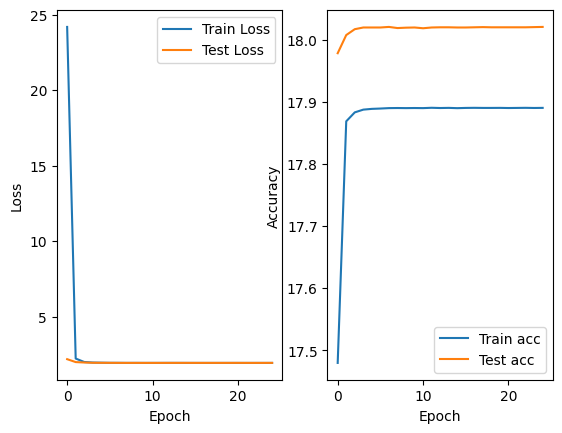

In [22]:
fig , ax = plt.subplots(1,2,sharex=True)

ax [0].plot(train_loss_steps, label='Train Loss')
ax [0].set_xlabel('Step')
ax [0].set_ylabel('Loss')
ax [0].legend()

ax [1].plot(train_acc_steps, label='Train Accuracy')
ax [1].set_xlabel('Step')
ax [1].set_ylabel('Accuracy')
ax [1].legend()

plt.savefig(results_dir + '/StepGraph.png')
plt.show() 

fig , ax = plt.subplots(1,2,sharex=True)

ax [0].plot(history['train_loss'], label='Train Loss')
ax [0].plot(history['val_loss'], label='Test Loss')
ax [0].set_xlabel('Epoch')
ax [0].set_ylabel('Loss')
ax [0].legend()

ax [1].plot(history['train_acc'], label='Train acc')
ax [1].plot(history['val_acc'], label='Test acc')
ax [1].set_xlabel('Epoch')
ax [1].set_ylabel('Accuracy')
ax [1].legend()

plt.savefig(results_dir + '/EpochGraph.png')
plt.show() 

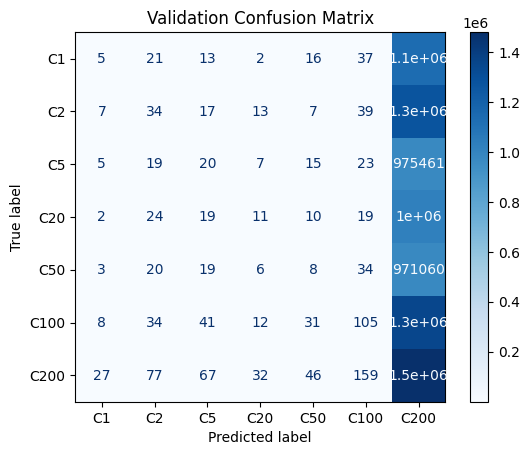

In [23]:
"""
Plot a confusion matrix using true and predicted labels.

Parameters:
    all_labels: List of true labels.
    all_preds: List of predicted labels.
    class_names: List of class names for labeling the confusion matrix.
"""
class_names = ['C1','C2','C5','C20','C50','C100','C200']
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
disp.figure_.savefig(results_dir + 'Confusion_Matrix.png')
plt.show()


In [24]:
print(f"after {num_epochs} epochs the trainning accuracy is {history["train_acc"][-1]} and the test accuaracy is {history["val_acc"][-1]} ")

test_accuracy_max= max(history["val_acc"])
train_accuracy_max=max(history["train_acc"])

idx_max_test_accuracy=history["val_acc"].index(test_accuracy_max)

idx_max_train_accuracy=history["train_acc"].index(train_accuracy_max)

print(f" the maximum accuracy of the test was {max(history["val_acc"])} at the epoch {idx_max_test_accuracy}")

print(f" the maximum accuracy of the train was {max(history["train_acc"])} at the epoch {idx_max_train_accuracy}")

print(f"the accuracy of the training at the best validation accuracy {max(history["val_acc"])} is {history["train_acc"][idx_max_test_accuracy]}  ")

after 25 epochs the trainning accuracy is 17.889965174034675 and the test accuaracy is 18.020272883115776 
 the maximum accuracy of the test was 18.020272883115776 at the epoch 6
 the maximum accuracy of the train was 17.890117418691837 at the epoch 11
the accuracy of the training at the best validation accuracy 18.020272883115776 is 17.889584562391764  


In [25]:
print(model.state_dict())
torch.save(model.state_dict(), results_dir + "model_weights.pth")

# model.load_state_dict(torch.load(results_dir + "model_weights.pth"))


OrderedDict({'fc1.weight': tensor([[-0.0300, -0.0184, -0.0250,  ..., -0.0371,  0.0048,  0.0131],
        [ 0.0083, -0.0021,  0.0023,  ...,  0.0221, -0.0067, -0.0357],
        [-0.0295, -0.0331,  0.0123,  ..., -0.0014, -0.0140,  0.0030],
        ...,
        [-0.0093,  0.0025, -0.0203,  ..., -0.0101,  0.0206, -0.0299],
        [ 0.0271, -0.0321,  0.0238,  ...,  0.0124, -0.0175, -0.0007],
        [-0.0269,  0.0164, -0.0276,  ...,  0.0237, -0.0154, -0.0292]],
       device='cuda:0'), 'fc1.bias': tensor([-0.0262, -0.0118, -0.0195, -0.0101, -0.0421, -0.0135, -0.0190, -0.0188,
         0.1067, -0.0245, -0.0174, -0.0321, -0.0407, -0.0218, -0.0167, -0.0357,
        -0.0071, -0.0239, -0.0303, -0.0393, -0.0276, -0.0264, -0.0596,  0.1396,
        -0.0521, -0.0529, -0.0252, -0.0223, -0.0258, -0.0520, -0.0407, -0.0457,
        -0.0097,  0.1018, -0.0390, -0.0426, -0.0624, -0.0143, -0.0475, -0.0252,
        -0.0110, -0.0453, -0.0101, -0.0189, -0.0356, -0.0143, -0.0270, -0.0154,
        -0.0491, -0.03

In [26]:
# Copy the 
shutil.copyfile('./mlp.ipynb', './' + results_dir + 'mlp_copy.ipynb')

'./Tests/2/mlp_copy.ipynb'